# Example 2: Haxby dataset #


************************************************************************
Haxby et al. (2001): Faces and Objects in Ventral Temporal Cortex (fMRI)
************************************************************************


**References**

1. Haxby, J., Gobbini, M., Furey, M., Ishai, A., Schouten, J., and Pietrini,
P.  (2001). Distributed and overlapping representations of faces and
objects in ventral temporal cortex. Science 293, 2425-2430.


In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

## `import` libraries ## 

In [2]:
import os

In [3]:
import dyneusr as ds
from dyneusr.mapper.wrappers import KMapperWrapper
from dyneusr.mapper.utils import optimize_cover, optimize_dbscan

In [4]:
import kmapper as km
import networkx as nx

In [5]:
import numpy as np
import pandas as pd
import scipy as sp

In [6]:
from sklearn.datasets.base import Bunch
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("paper", "white")
%matplotlib inline

## Load `data` ##

In [8]:
from load_data import load_haxby, Bunch

# load dataset
haxby = load_haxby(subjects=-1, sessions=[4,5], targets=None)

# extract subjects
subjects = haxby.subjects
for i, subject in enumerate(subjects):
    print(i, subject.name, subject.data.shape, subject.target.shape)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


0 subj1_sess4_5 (242, 577) (242, 9)
1 subj2_sess4_5 (242, 464) (242, 9)
2 subj3_sess4_5 (242, 307) (242, 9)
3 subj4_sess4_5 (242, 675) (242, 9)
4 subj5_sess4_5 (242, 422) (242, 9)
5 subj6_sess4_5 (242, 348) (242, 9)


### Visual inspection of data, meta ###

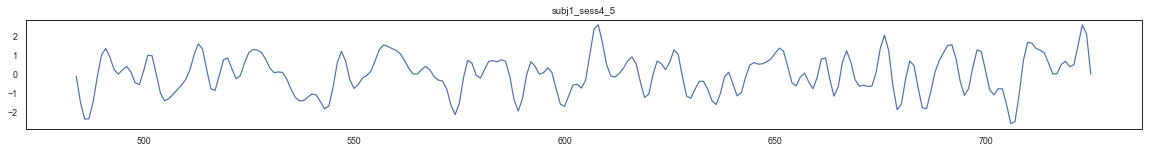

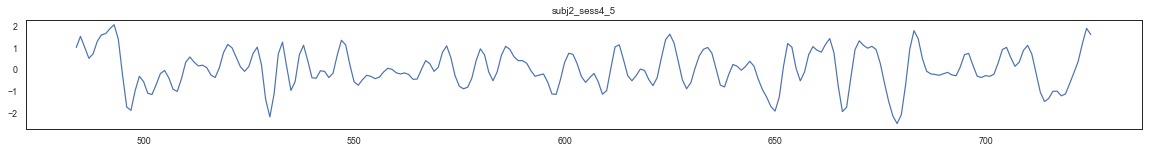

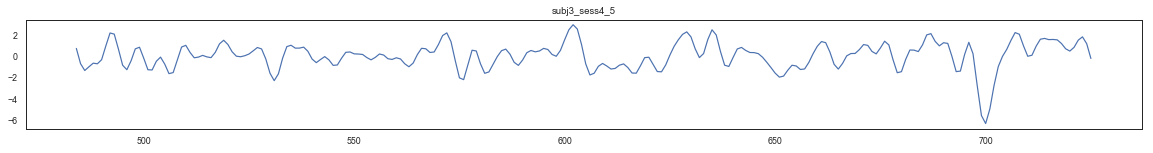

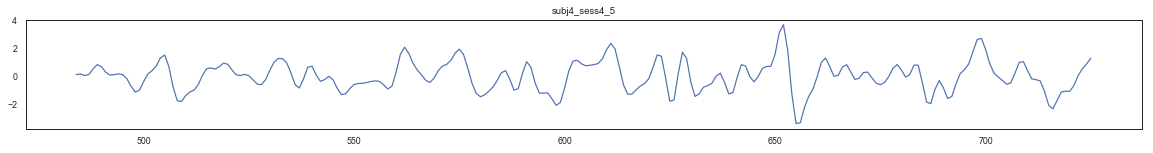

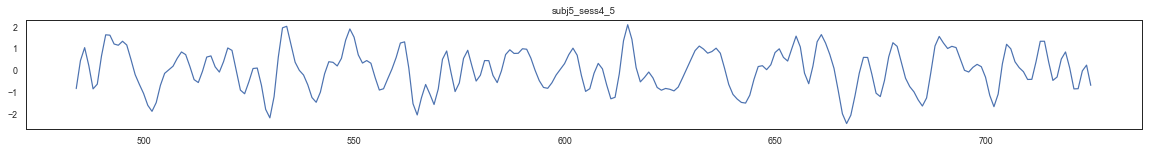

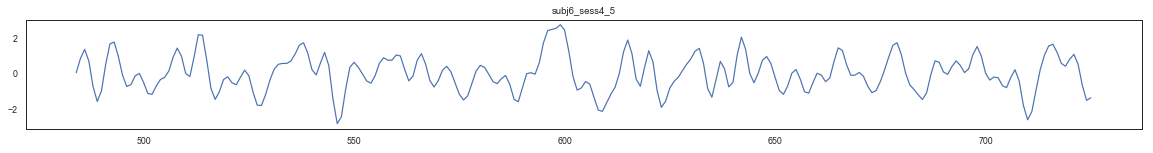

In [9]:
for subject in haxby.subjects:
    _ = subject.data.iloc[:,:1].plot(figsize=(20,2), legend=False, title=subject.name)

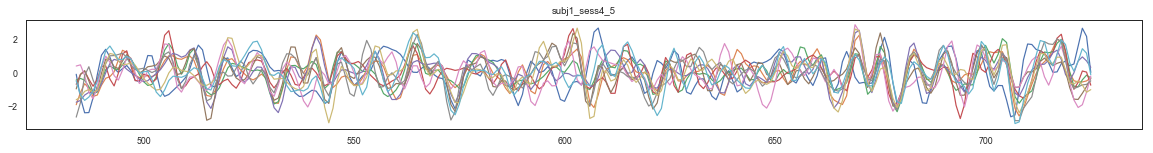

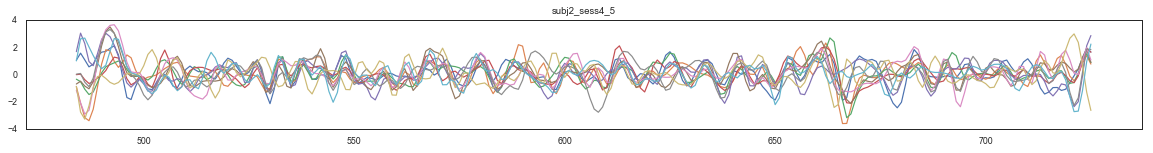

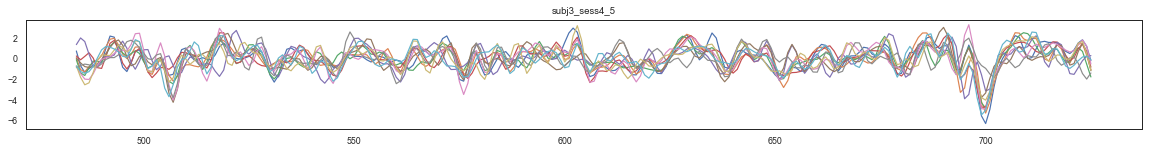

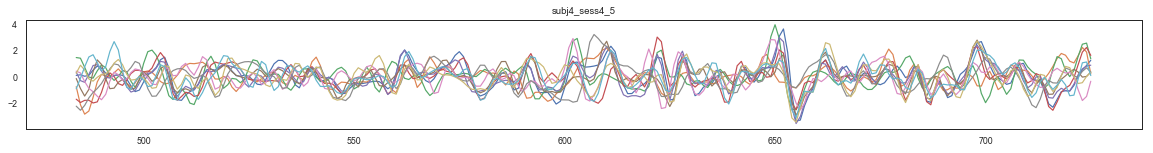

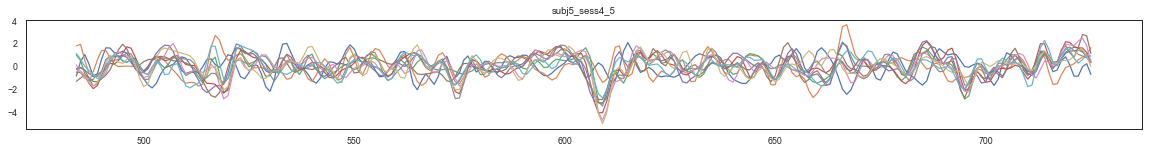

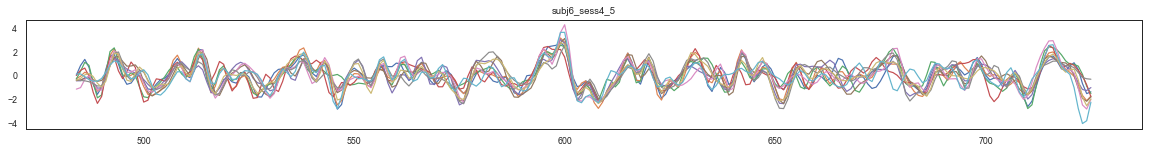

In [10]:
for subject in haxby.subjects:
    _ = subject.data.iloc[:,:10].plot(figsize=(20,2), legend=False, title=subject.name)

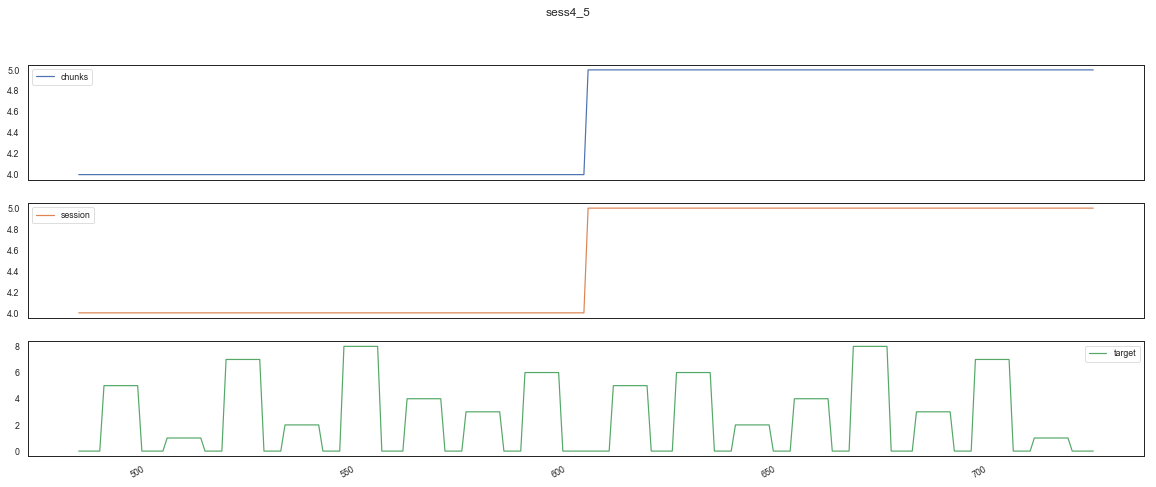

In [11]:
_ = haxby.meta.plot(figsize=(20,8),  subplots=True, title=haxby.session_code)

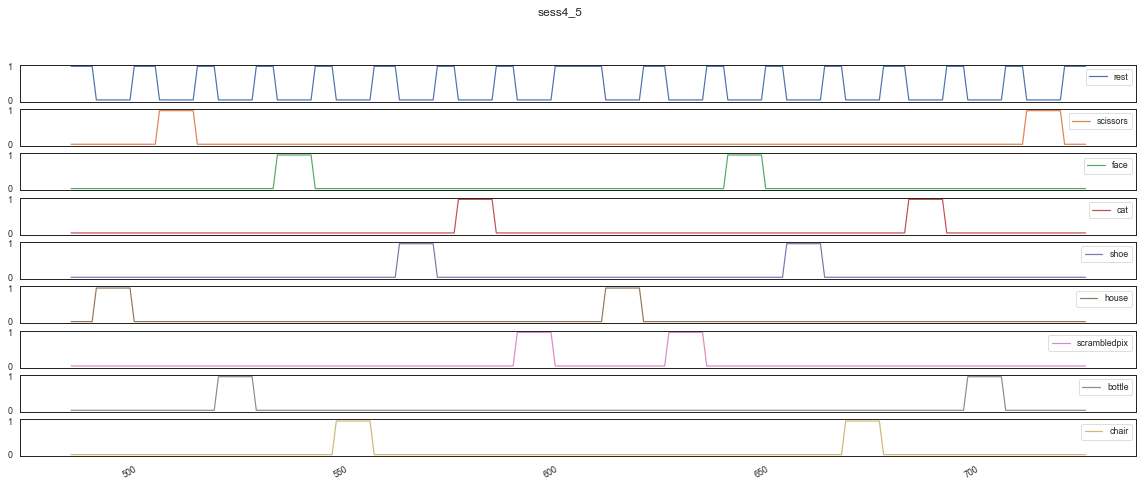

In [12]:
_ = haxby.target.plot(figsize=(20,8),  subplots=True, title=haxby.session_code)
   

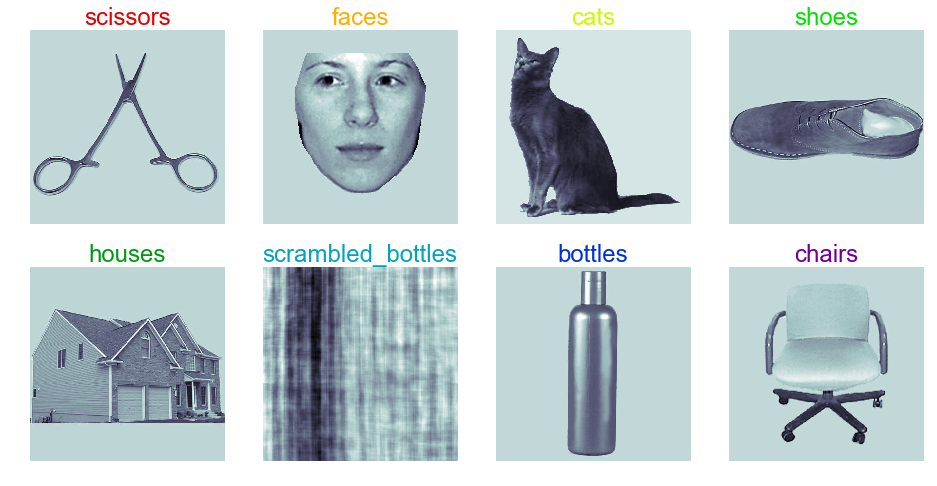

In [13]:
# visualize example of each stim    
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = np.ravel(axes)
for ax, stim_ in zip(axes, haxby.target.columns[1:]):
    stim = str(stim_)
    if 'scrambledpix' in stim:
        stim = 'controls'
    elif not stim.endswith('s'):
        stim += 's'
    # get fn
    stim_fn = haxby.stimuli[stim][0]
    if stim in ['scrambledpix', 'controls']:
        stim, stim_fn = haxby.stimuli['controls'][0]
        stim_fn = stim_fn[0] 
    stim_im = plt.imread(stim_fn, format='jpg')
    ax.imshow(stim_im, cmap='bone')
    ax.set_title(stim, fontsize=24, color=haxby.target_colors[haxby.target_names.index(stim_)])    
    ax.axis('off')

(0.0, 242.0, 242.0, 0.0)

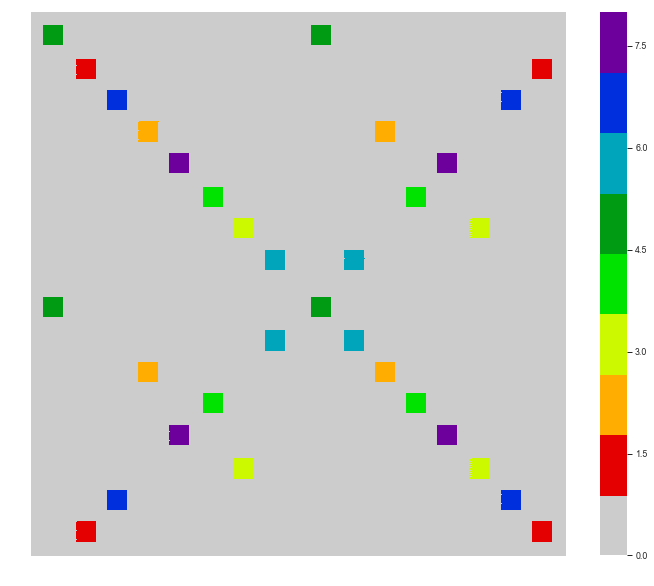

In [14]:
# extract subset of meta
y = haxby.target.copy()
y_block = y.dot(y.T) * haxby.meta.target

# plot
fig, ax = plt.subplots(1,1,figsize=(12,10))
_ = sns.heatmap(y_block, ax=ax, square=not True, cbar=True, cmap=haxby.cmap)
ax.axis('off')


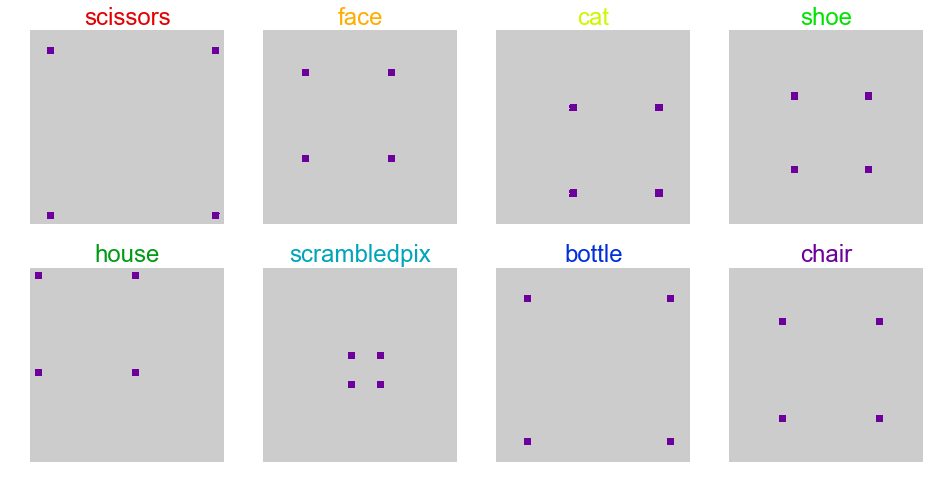

In [15]:
# visualize example of each stim    
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = np.ravel(axes)
for ax, stim in zip(axes, y.columns[1:]):
    # get y block for col
    y_block_ = (y_block == list(y.columns).index(stim)).astype(int)
    
    # plot 
    c = haxby.target_names.index(stim)
    sns.heatmap(y_block_ * c, ax=ax, square=True, cbar=False, cmap=haxby.cmap)
    ax.set_title(stim, fontsize=24, color=haxby.cmap(c))
    ax.axis('off')


## Generate $MAPPER$ graph + visualize with `dyneusr` ##

[subject subj1_sess4_5]
X has shape: (242, 577)
y has shape: (242, 9)

Mapping...

projection = TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='exact', metric='euclidean', min_grad_norm=1e-07, n_components=2,
   n_iter=1000, n_iter_without_progress=300, perplexity=50, random_state=0,
   verbose=0)

clusterer = DBSCAN(algorithm='auto', eps=26.3271381223901, leaf_size=15,
    metric='minkowski', metric_params=None, min_samples=2, n_jobs=1, p=2)

cover = {'n_cubes': 17, 'perc_overlap': 0.67, 'limits': array([[-0.04466667,  1.04466667],
       [-0.04466667,  1.04466667]])}

Visualizing...


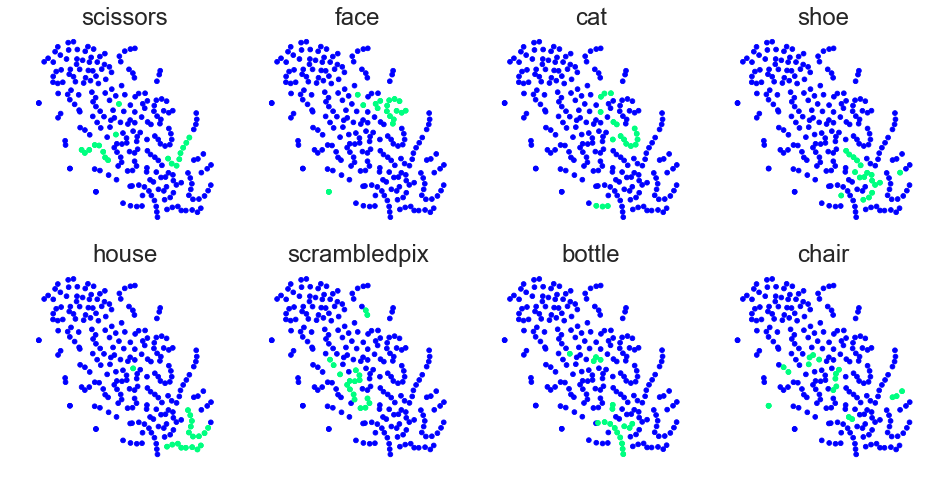

label,group,value,row_count
rest,0,97.00,241
scissors,1,18.00,241
face,2,18.00,241
cat,3,18.00,241
shoe,4,18.00,241
house,5,18.00,241
scrambledpix,6,18.00,241
bottle,7,18.00,241
chair,8,18.00,241



dG.M: (242, 166)
Saving TCM for subject... results/haxby_subj1_sess4_5_TCM.npy
Already serving localhost:8802 
[Force Graph] http://localhost:8802/haxby_subj1_sess4_5.html




[subject subj2_sess4_5]
X has shape: (242, 464)
y has shape: (242, 9)

Mapping...

projection = TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='exact', metric='euclidean', min_grad_norm=1e-07, n_components=2,
   n_iter=1000, n_iter_without_progress=300, perplexity=50, random_state=0,
   verbose=0)

clusterer = DBSCAN(algorithm='auto', eps=27.605001592992302, leaf_size=15,
    metric='minkowski', metric_params=None, min_samples=2, n_jobs=1, p=2)

cover = {'n_cubes': 17, 'perc_overlap': 0.67, 'limits': array([[-0.04466667,  1.04466667],
       [-0.04466667,  1.04466667]])}

Visualizing...


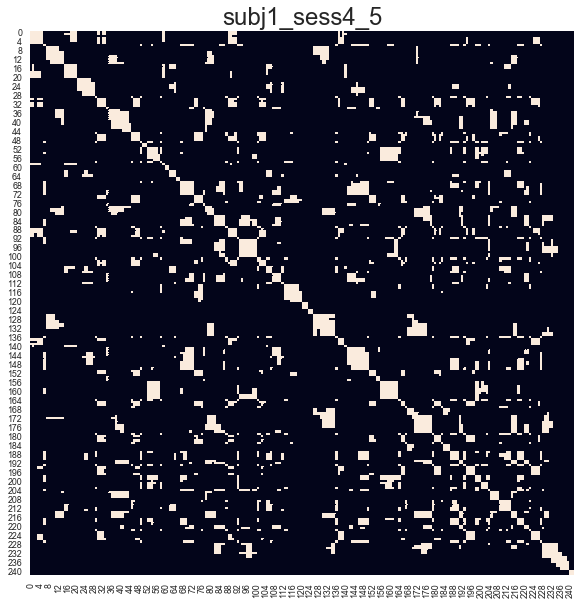

<Figure size 432x288 with 0 Axes>

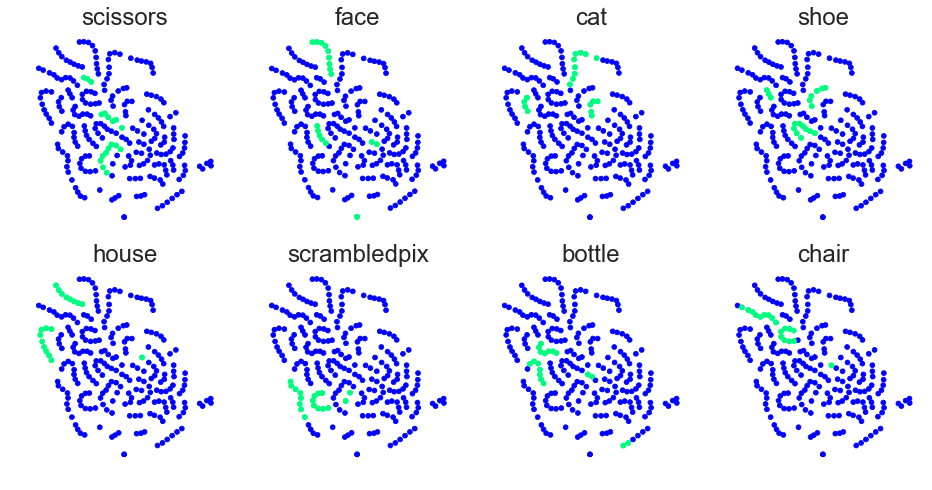

label,group,value,row_count
rest,0,97.00,241
scissors,1,18.00,241
face,2,18.00,241
cat,3,18.00,241
shoe,4,18.00,241
house,5,18.00,241
scrambledpix,6,18.00,241
bottle,7,18.00,241
chair,8,18.00,241



dG.M: (242, 159)
Saving TCM for subject... results/haxby_subj2_sess4_5_TCM.npy
Already serving localhost:8802 
[Force Graph] http://localhost:8802/haxby_subj2_sess4_5.html




[subject subj3_sess4_5]
X has shape: (242, 307)
y has shape: (242, 9)

Mapping...

projection = TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='exact', metric='euclidean', min_grad_norm=1e-07, n_components=2,
   n_iter=1000, n_iter_without_progress=300, perplexity=50, random_state=0,
   verbose=0)

clusterer = DBSCAN(algorithm='auto', eps=24.668255970446275, leaf_size=15,
    metric='minkowski', metric_params=None, min_samples=2, n_jobs=1, p=2)

cover = {'n_cubes': 17, 'perc_overlap': 0.67, 'limits': array([[-0.04466667,  1.04466667],
       [-0.04466667,  1.04466667]])}

Visualizing...


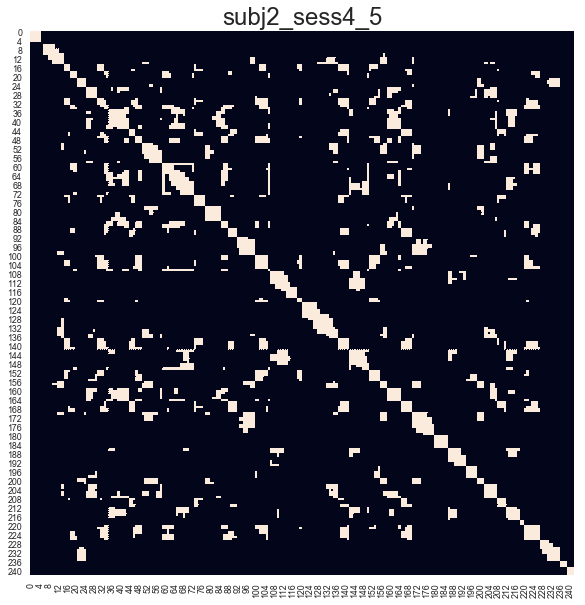

<Figure size 432x288 with 0 Axes>

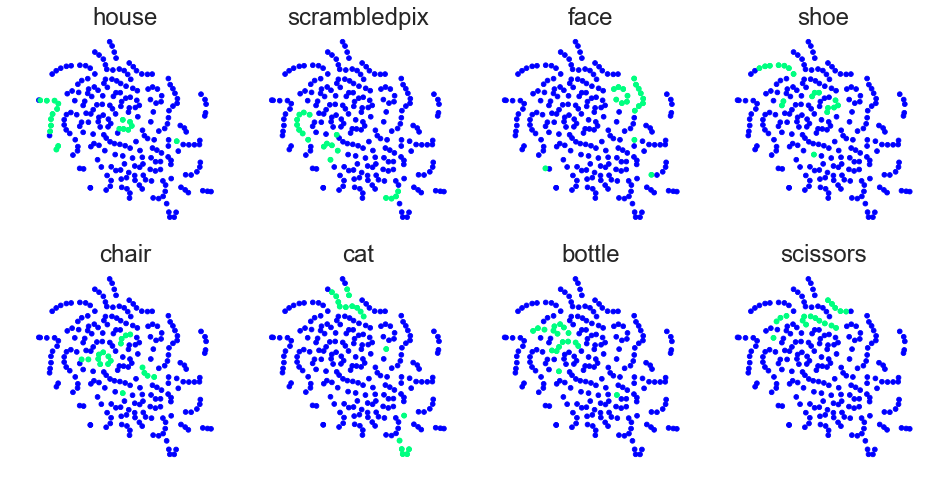

label,group,value,row_count
rest,0,97.00,241
house,1,18.00,241
scrambledpix,2,18.00,241
face,3,18.00,241
shoe,4,18.00,241
chair,5,18.00,241
cat,6,18.00,241
bottle,7,18.00,241
scissors,8,18.00,241



dG.M: (242, 166)
Saving TCM for subject... results/haxby_subj3_sess4_5_TCM.npy
Already serving localhost:8802 
[Force Graph] http://localhost:8802/haxby_subj3_sess4_5.html




[subject subj4_sess4_5]
X has shape: (242, 675)
y has shape: (242, 9)

Mapping...

projection = TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='exact', metric='euclidean', min_grad_norm=1e-07, n_components=2,
   n_iter=1000, n_iter_without_progress=300, perplexity=50, random_state=0,
   verbose=0)

clusterer = DBSCAN(algorithm='auto', eps=28.004985102867675, leaf_size=15,
    metric='minkowski', metric_params=None, min_samples=2, n_jobs=1, p=2)

cover = {'n_cubes': 17, 'perc_overlap': 0.67, 'limits': array([[-0.04466667,  1.04466667],
       [-0.04466667,  1.04466667]])}

Visualizing...


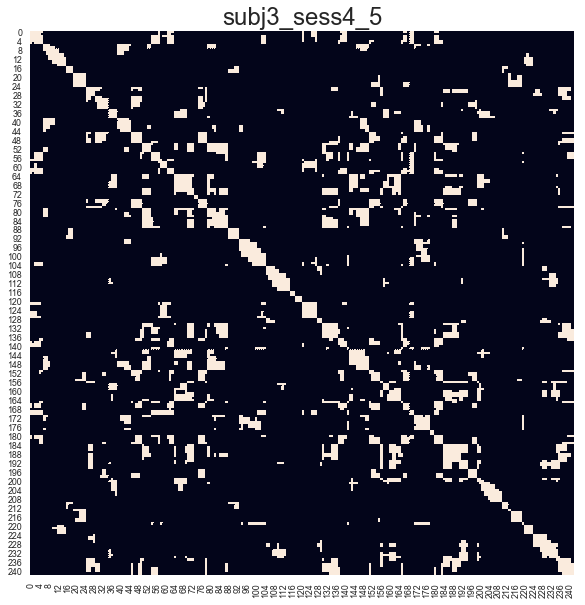

<Figure size 432x288 with 0 Axes>

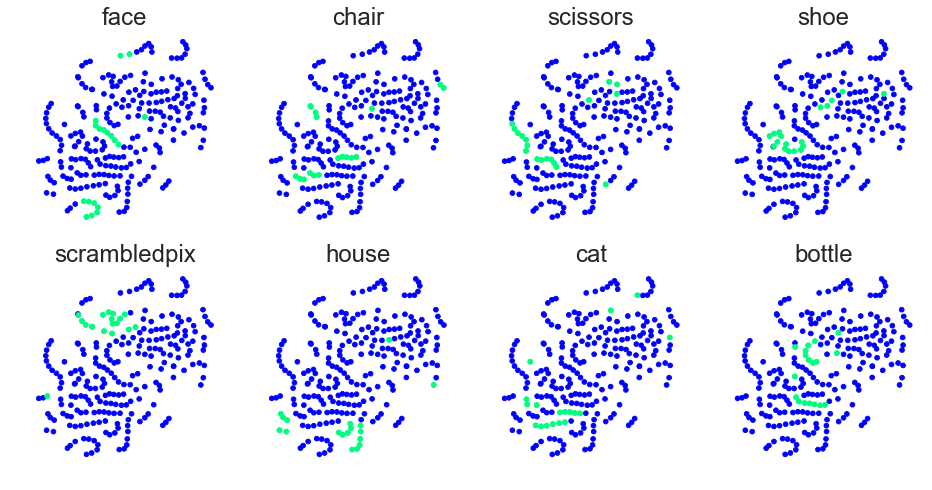

label,group,value,row_count
rest,0,97.00,241
face,1,18.00,241
chair,2,18.00,241
scissors,3,18.00,241
shoe,4,18.00,241
scrambledpix,5,18.00,241
house,6,18.00,241
cat,7,18.00,241
bottle,8,18.00,241



dG.M: (242, 160)
Saving TCM for subject... results/haxby_subj4_sess4_5_TCM.npy
Already serving localhost:8802 
[Force Graph] http://localhost:8802/haxby_subj4_sess4_5.html




[subject subj5_sess4_5]
X has shape: (242, 422)
y has shape: (242, 9)

Mapping...

projection = TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='exact', metric='euclidean', min_grad_norm=1e-07, n_components=2,
   n_iter=1000, n_iter_without_progress=300, perplexity=50, random_state=0,
   verbose=0)

clusterer = DBSCAN(algorithm='auto', eps=23.616781132201332, leaf_size=15,
    metric='minkowski', metric_params=None, min_samples=2, n_jobs=1, p=2)

cover = {'n_cubes': 17, 'perc_overlap': 0.67, 'limits': array([[-0.04466667,  1.04466667],
       [-0.04466667,  1.04466667]])}

Visualizing...


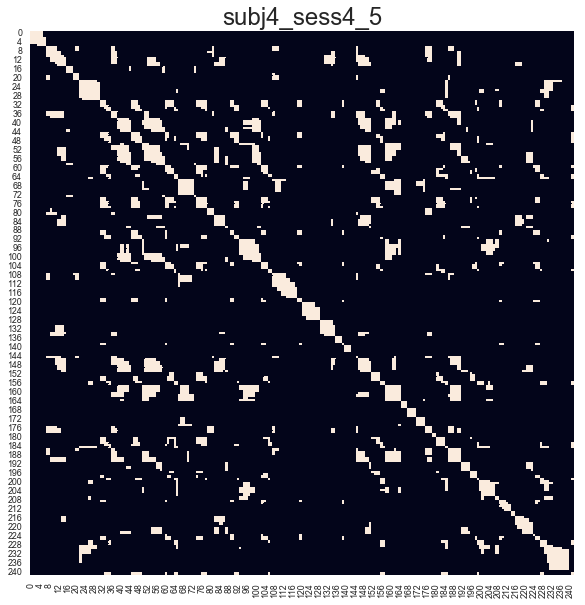

<Figure size 432x288 with 0 Axes>

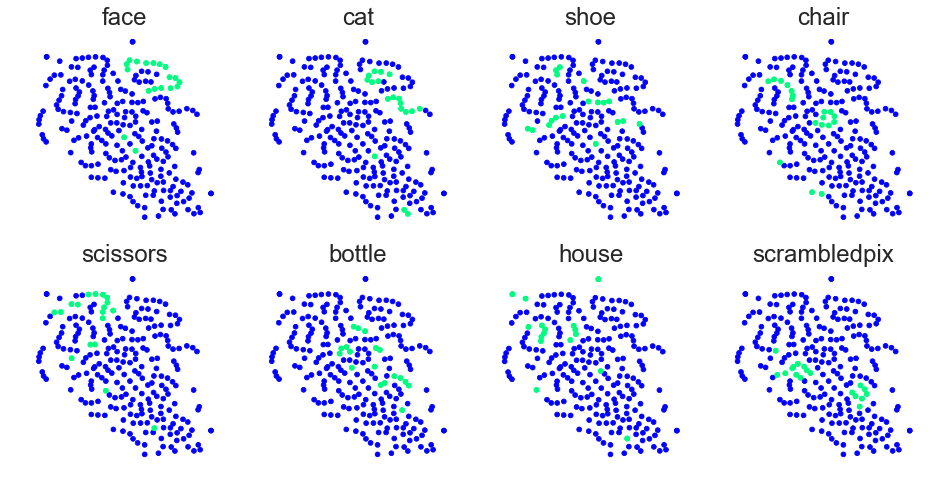

label,group,value,row_count
rest,0,97.00,241
face,1,18.00,241
cat,2,18.00,241
shoe,3,18.00,241
chair,4,18.00,241
scissors,5,18.00,241
bottle,6,18.00,241
house,7,18.00,241
scrambledpix,8,18.00,241



dG.M: (242, 173)
Saving TCM for subject... results/haxby_subj5_sess4_5_TCM.npy
Already serving localhost:8802 
[Force Graph] http://localhost:8802/haxby_subj5_sess4_5.html




[subject subj6_sess4_5]
X has shape: (242, 348)
y has shape: (242, 9)

Mapping...

projection = TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='exact', metric='euclidean', min_grad_norm=1e-07, n_components=2,
   n_iter=1000, n_iter_without_progress=300, perplexity=50, random_state=0,
   verbose=0)

clusterer = DBSCAN(algorithm='auto', eps=20.11123226958869, leaf_size=15,
    metric='minkowski', metric_params=None, min_samples=2, n_jobs=1, p=2)

cover = {'n_cubes': 17, 'perc_overlap': 0.67, 'limits': array([[-0.04466667,  1.04466667],
       [-0.04466667,  1.04466667]])}
________________________________________________________________________________
[Memory] Calling dyneusr.mapper.wrappers._transform_lens...
_transform_lens(X=array([[ 0.03125 , ..., -0.492789],
       ...,
       [-1.385313, ..., -2.050669]], dtype=float32), projection=TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='exact', metric='euclidean', 

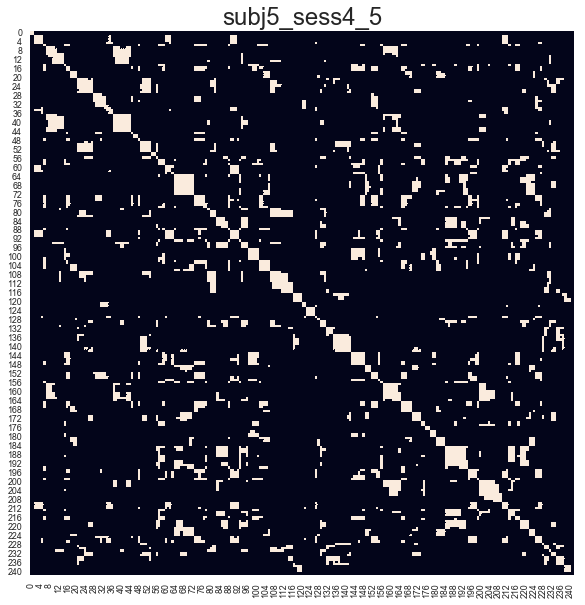

<Figure size 432x288 with 0 Axes>

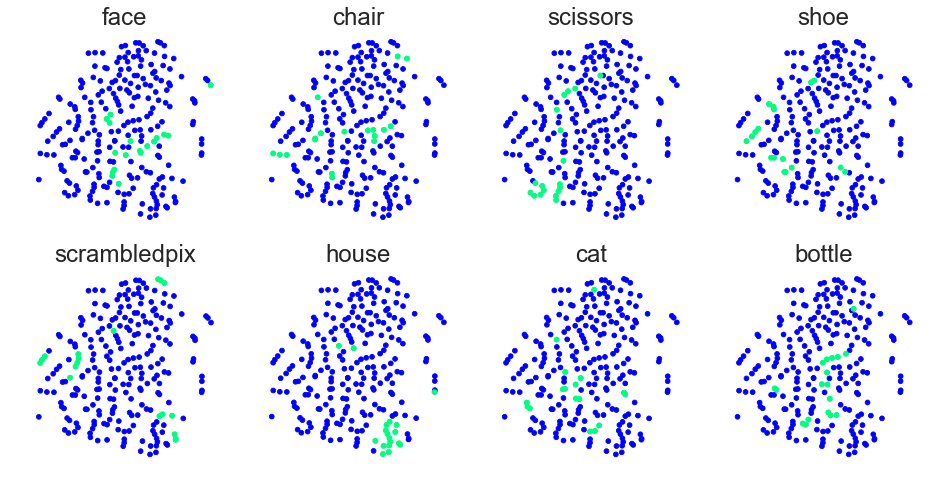

label,group,value,row_count
rest,0,97.00,241
face,1,18.00,241
chair,2,18.00,241
scissors,3,18.00,241
shoe,4,18.00,241
scrambledpix,5,18.00,241
house,6,18.00,241
cat,7,18.00,241
bottle,8,18.00,241



dG.M: (242, 169)
Saving TCM for subject... results/haxby_subj6_sess4_5_TCM.npy
Already serving localhost:8802 
[Force Graph] http://localhost:8802/haxby_subj6_sess4_5.html


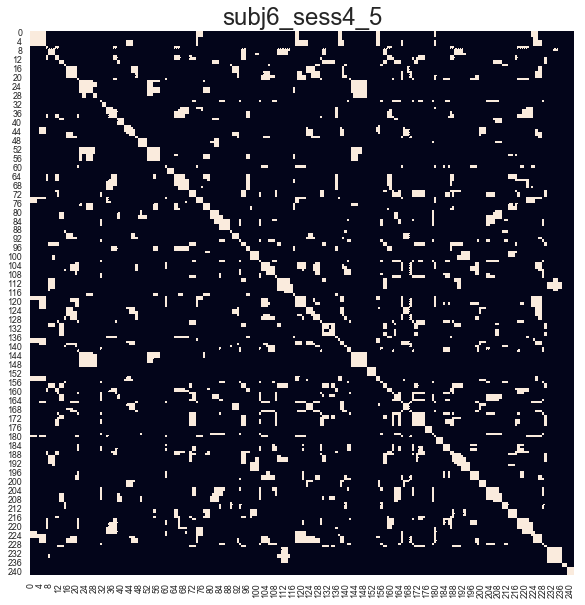

<Figure size 432x288 with 0 Axes>

In [16]:
# loop over sessions, run for each
for i, subject in enumerate(subjects):
    
    ### Setup 
    X = subject.data.values.copy()
    y = subject.target.copy()
    print('[subject {}]'.format(subject.name))
    print('X has shape: {}'.format(X.shape))
    print('y has shape: {}'.format(y.shape))

    
    ### Run MAPPER
    print("\nMapping...")
    projection = TSNE(perplexity=50, random_state=0, init='pca', method='exact')
    clusterer = optimize_dbscan(X)
    cover = optimize_cover(X, r=15, g=0.67, scale_r=not True, scale_limits=True)
    print('\nprojection = {}'.format(projection))
    print('\nclusterer = {}'.format(clusterer))
    print('\ncover = {}'.format(cover.__dict__))
    
    # run kmapper 
    mapper = KMapperWrapper(memory='dyneusr_cache/{}'.format(subject.name))    
    mapper.fit_lens(X, projection=projection)        
    mapper.fit_graph(data=X, clusterer=clusterer, cover=cover)
    
    # extract results
    lens = mapper.lens_.copy()
    graph = dict(mapper.graph_)
    
    ### Visualize MAPPER
    print("\nVisualizing...")
    # visualize lens
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    c_cols = [_ for _ in y.columns if _ not in ['rest']]
    for ax, stim in zip(np.ravel(axes), c_cols):
        y_mask = (y[stim] == 1)
        ax.scatter(*lens.T, c=y[stim], cmap='winter')    
        ax.scatter(*lens[y_mask].T, c=y[y_mask][stim], cmap='winter_r')
        ax.set_title(stim, fontsize=24)    
        ax.axis('off')  
    plt.show()
    
    # fit DyNeuGraph
    dG = ds.DyNeuGraph(G=graph, y=y, colors=haxby.target_colors, cmap=haxby.cmap)
    print('\ndG.M:', dG.M.shape)
   
    # save tcm
    print('Saving TCM for subject...', end=' ')
    tcm_npy = 'results/haxby_{}_TCM.npy'.format(subject.name)
    np.save(tcm_npy, dG.TCM)
    print(tcm_npy)
   
    # plot matrices
    ax = sns.heatmap(dG.TCM, figure=plt.figure(figsize=(10,10)), square=True, cbar=False)
    ax.set_title(subject.name, fontsize=24)
                
    # vis d3-force
    dG.visualize('haxby_{}.html'.format(subject.name),  path_assets='results', show=True, port=8802)
    
    
    # store data
    subject.mapped = Bunch(
        data=X,
        lens=lens,
        graph=graph,
        dG=dG, X=X, y=y
        )
    subjects[i] = subject
    
    # finish 
    print()
    print()  

## Anchor to anatomy ##

In [17]:
# choose a subject
i = 0
subject = subjects[i]

# extract some variables
data = subject.data
meta = subject.meta
dG = subject.mapped.dG
y = subject.meta.labels.values

# print some info
print('Subject: {}'.format(subject.name)) 
node_labels = {n:'|'.join(list(set(y[dG.G_.nodes[n]['members']]))) for n in dG.G_}
TR_labels = [_ for _ in y]

# anchor to anat
node_images = ds.tools.mixture.simple_mixtures(
    subject, mixtures=dG.mixtures_,
    save_dir='results/tooltips_{}'.format(subject.name), 
    prefix='TR_',targets=TR_labels,
    show_every_n=10, print_every_n=10,
    threshold="90%", fwhm=4, 
    mode='glass', 
    figsize=(4, 4), 
    plot_kws=dict(
        display_mode='z', cut_coords=1, threshold=0.25, colorbar=False, 
        ),
    )
dG.annotate(image=node_images)

# vis d3-force
dG.visualize('haxby_anat_{}.html'.format(subject.name), path_assets='results', show=True, port=8802)

Subject: subj1_sess4_5
[done]
Already serving localhost:8802 
[Force Graph] http://localhost:8802/haxby_anat_subj1_sess4_5.html


DyNeuGraph()

<Figure size 432x288 with 0 Axes>

In [18]:
# choose a subject
i = 0
subject = subjects[i]

# extract some variables
data = subject.data
meta = subject.meta
dG = subject.mapped.dG
y = subject.meta.labels.values

# print some info
print('Subject: {}'.format(subject.name)) 
node_labels = {n:'|'.join(list(set(y[dG.G_.nodes[n]['members']]))) for n in dG.G_}

# anchor to anat
node_images = ds.tools.mixture.simple_mixtures(
    subject, mixtures=dict(dG.G_.nodes("members")),
    save_dir='results/tooltips_{}'.format(subject.name), 
    prefix='node_',targets=node_labels,
    show_every_n=10, print_every_n=10,
    threshold="90%", fwhm=4, 
    mode='glass', 
    figsize=(4, 4), 
    plot_kws=dict(
        display_mode='z', cut_coords=1, threshold=0.25, colorbar=False, 
        ),
    )
dG.annotate(image=node_images)

# vis d3-force
dG.visualize('haxby_anat_node_{}.html'.format(subject.name), path_assets='results', show=True, port=8802)

Subject: subj1_sess4_5
[done]
Already serving localhost:8802 
[Force Graph] http://localhost:8802/haxby_anat_node_subj1_sess4_5.html


DyNeuGraph()

<Figure size 432x288 with 0 Axes>

## Capture temporal transitions ##

In [19]:
# combine all TCMs
TCMs = np.array([_.mapped.dG.TCM.copy() for _ in subjects])
print("TCMs has shape:", TCMs.shape)

# mean
mean_TCM = TCMs.mean(axis=0)
print("mean TCM has shape:", mean_TCM.shape)

# save
print('Saving TCMs...', end=' ')
np.save('results/haxby_TCMs_{}.npy'.format(haxby.session_code), TCMs)
np.save('results/haxby_mean_TCM_{}.npy'.format(haxby.session_code), mean_TCM)

TCMs has shape: (6, 242, 242)
mean TCM has shape: (242, 242)
Saving TCMs... 

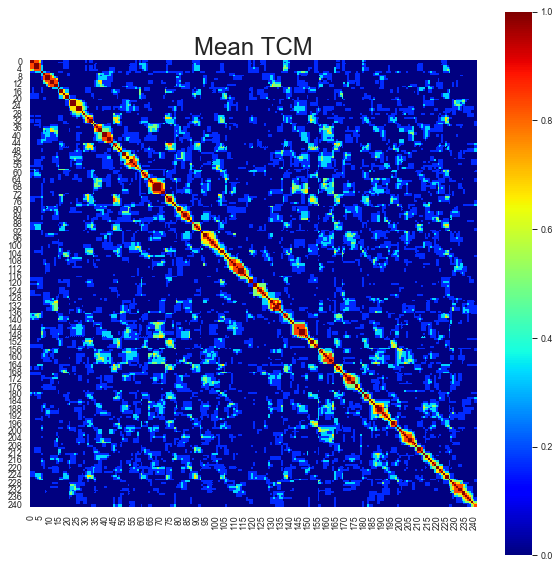

In [20]:
# plot heatmap
ax = sns.heatmap(mean_TCM, figure=plt.figure(figsize=(10,10)), square=True, cbar=True, cmap='jet')
ax.set_title('Mean TCM', fontsize=24)
plt.savefig('results/haxby_mean_TCM_{}.jpg'.format(haxby.session_code), dpi=300, transparent=True)

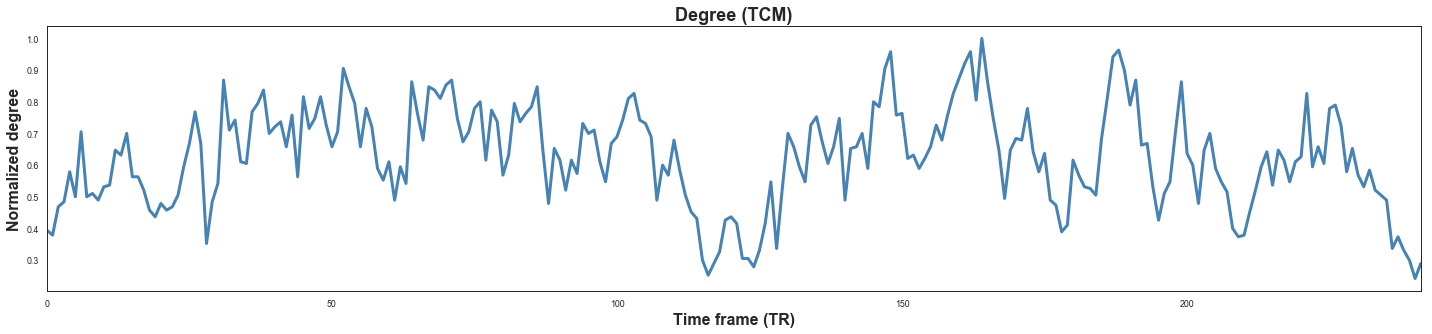

In [21]:
# plot temporal evolution
ds.visuals.plot_temporal_degree(mean_TCM, window=1, show=False)
plt.savefig('results/haxby_mean_TCM_degree_{}.jpg'.format(haxby.session_code), dpi=300, transparent=True)

### Color temporal connectivity by visual stimuli ###

In [22]:
def draw_meta(ax=None, trs=None):
    """ Draw event bounding boxes on axes. """
    ax = ax or plt.gca()
    for i, y_col in enumerate(haxby.target.columns[:]):
        y_mask = (haxby.target[y_col] == 1)
        c = list(haxby.target.columns).index(y_col)
        for sess in set(haxby.meta.session):
            sess_mask = y_mask & (haxby.meta.session==sess) 
            
            # draw bounds
            plt.fill_between(
                trs[sess_mask], 0, 1, 
                alpha=0.1, color=haxby.cmap(c))        
            
            # top, bottom
            plt.plot(
                trs[sess_mask], sess_mask[sess_mask],
                marker='',ls='-', lw=3, alpha=.9, color=haxby.cmap(c))    
    return ax


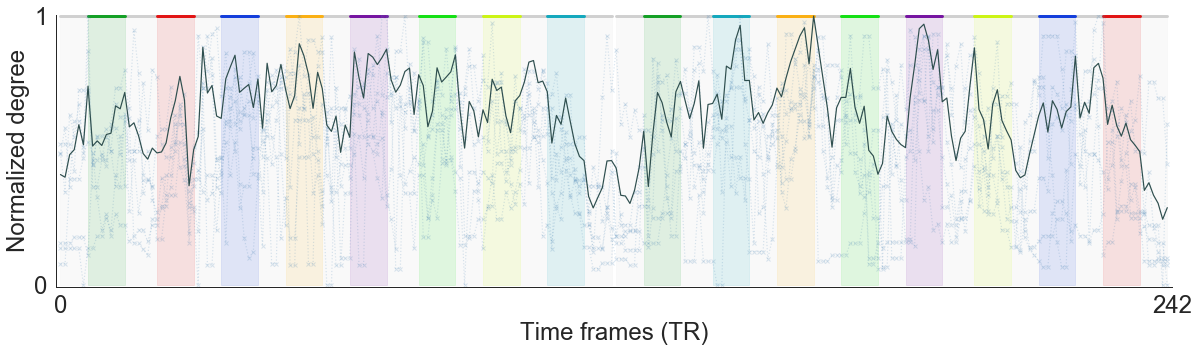

In [23]:
# compute degree for each TCM
np_degs = np.array([list(dict(nx.Graph(_).degree()).values()) for _ in TCMs])
np_degs_norm = np_degs / np_degs.max(axis=-1, keepdims=True)
np_degs_mean = np_degs_norm.mean(axis=0)
np_degs_mean /= np_degs_mean.max()

#  number or TRs to track
trs = np.arange(np_degs.shape[-1])

# plot together
plt.figure(figsize=(20,5))
ax = draw_meta(trs=trs)

# plot individual subjects
for deg in np_degs_norm:  
    plt.plot(trs, deg, marker='x',ls=':', alpha=0.2, color='steelblue')
    
# overlay with mean
plt.plot(trs, np_degs_mean, alpha=1, marker='',ls='-', color='darkslategray')


### finish
# labels
plt.xlabel('Time frames (TR)', fontsize=24)
plt.ylabel('Normalized degree', fontsize=24)

# set xticks
plt.xticks([0, len(trs)], fontsize=24)
plt.yticks([0, 1], fontsize=24)

# set xlim
plt.xlim(-1, len(trs))
plt.ylim(-0.005, 1.005)

# remove axes)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')